In [1]:
import pandas as pd
import sys
import csv
from pprint import pprint
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from nltk.corpus import stopwords

ModuleNotFoundError: No module named 'stop_words'

In [ ]:
import re
import csv
import sys
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
pd.options.display.max_columns = 100

In [5]:
csv.field_size_limit(sys.maxsize)
# Data files are in "../Data/Seattle/"
df_review = pd.read_csv('Seattle/individual_review_inspection_merged.csv', sep=None,engine='python')
df_merged = pd.read_csv('Seattle/instances_mergerd_seattle.csv', sep=None,engine='python')
# df_LA = pd.read_csv('LA_reviews.csv')

In [6]:
print(df_review.shape)
print(df_merged.shape)

(162310, 21)
(13299, 13)


In [50]:
df_review.head()

,Unnamed: 0,inspection_id,restaurant_id,inspection_period_start_date,inspection_period_end_date,inspection_penalty_score,inspection_average_prev_penalty_scores,inspection_prev_penalty_score,cuisines,zip_code,review_count,non_positive_review_count,average_review_rating,inspection_year,inspection_month,review_id,user_id,locality,review_date,rating,content
0,10,DA2383404,ZriNDCVxkCdVEO-X2sjHFw,2012-02-06,2012-10-02,0,22.384615,35,"['Japanese', 'Restaurants']",98116,1,0,5.000000,2012,10,review_Q9_9A9QmmpX4unYRcEQc8g,iU3Vwjf1ZJUl5r_Ha2jjbA,Seattle,2012-02-20,5.0,We went here this past weekend with zero expec...
1,27,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,2011-11-03,2012-02-06,0,23.272727,40,"['Japanese', 'Restaurants']",98116,3,0,4.000000,2012,2,review_IveKyEloRTk8bHJ8xcpalA,3SSp4anHG1zPxurm8ahwfA,Seattle,2012-01-01,4.0,Lots of young families . Kind of sparse &#160;...
2,36,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,2011-11-03,2012-02-06,0,23.272727,40,"['Japanese', 'Restaurants']",98116,3,0,4.000000,2012,2,review_1pIZlx4k7U8S-_dX-kzb4w,BKYMMC-DAPY-Oo14tdWA0A,Seattle,2011-11-15,4.0,Our favorite teriyaki in West Seattle! Generou...
3,45,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,2011-11-03,2012-02-06,0,23.272727,40,"['Japanese', 'Restaurants']",98116,3,0,4.000000,2012,2,review_iaieVt5Tm_US0LTsHMSC6Q,lBPuoOFE7jRMpgvj40A1lQ,Seattle,2011-11-13,4.0,Seattle has a lot of great teriyaki. &#160;Thi...
4,54,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,2011-01-06,2011-11-03,40,21.600000,10,"['Japanese', 'Restaurants']",98116,7,0,4.428571,2011,11,review_WxjHfhYRD3heTI6ETb7sdg,01jx8LovEJpYkaDAg5-g_A,Seattle,2011-01-26,4.0,This place is a gem! My husband and I didn't h...


In [7]:
# Seattle
df = df_review[['inspection_id','restaurant_id','review_id','inspection_penalty_score', 'rating', 'content']]

In [70]:
#LA
df_LA = df_LA[df_LA.categories.notnull()]
df_LA_restaurants = df_LA[df_LA['categories'].str.contains('Restaurants')]
df = df_LA_restaurants[['review_id','business_id','stars', 'text']]
df.stars = pd.to_numeric(df.stars, errors='coerce')

//anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [5]:
df.shape

(162310, 6)

In [6]:
df.head()

,inspection_id,restaurant_id,review_id,inspection_penalty_score,rating,content
0,DA2383404,ZriNDCVxkCdVEO-X2sjHFw,review_Q9_9A9QmmpX4unYRcEQc8g,0,5.0,We went here this past weekend with zero expec...
1,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_IveKyEloRTk8bHJ8xcpalA,0,4.0,Lots of young families . Kind of sparse &#160;...
2,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_1pIZlx4k7U8S-_dX-kzb4w,0,4.0,Our favorite teriyaki in West Seattle! Generou...
3,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_iaieVt5Tm_US0LTsHMSC6Q,0,4.0,Seattle has a lot of great teriyaki. &#160;Thi...
4,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_WxjHfhYRD3heTI6ETb7sdg,40,4.0,This place is a gem! My husband and I didn't h...


In [73]:
# unhygienic = df[(df.inspection_penalty_score > 70) & (df.rating < 3)]
negative = df[df.stars < 3]

In [74]:
print(negative.shape)
pprint(negative.business_id.value_counts()[:5])

(190004, 4)
eoHdUeQDNgQ6WYEnP2aiRw    1284
RESDUcs7fIiihp38-d6_6g    1283
El4FC8jcawUVgw_0EIcbaQ    1254
K7lWdNUhCbcnEvI0NhGewg    1042
ujHiaprwCQ5ewziu0Vi9rw     943
Name: business_id, dtype: int64


In [75]:
negative.head()

,review_id,business_id,stars,text
2435,QgSf2JvYz-M4PU2yuJjxNQ,9Jc3W0aR9Xf2gcHI0rEXsw,1,"After being scared away from Rock & Rita's, we..."
2436,Pj41wBNrL1TPM0aKwqGNgQ,9Jc3W0aR9Xf2gcHI0rEXsw,2,Came here for dinner b/c we arrived at the hot...
2437,D7YruuihDlR2ASh1vvankw,9Jc3W0aR9Xf2gcHI0rEXsw,2,There is no more prime rib. According to the w...
2441,wDy6u9gubYppkjtlGvd-iA,9Jc3W0aR9Xf2gcHI0rEXsw,2,Place is meh. I give it 2.5 star. \nAbout th...
2442,fpPsWHxNta9wLfURSVRpuw,9Jc3W0aR9Xf2gcHI0rEXsw,1,What can i say about this?\nAll i can say is g...


In [95]:
negative_sample = negative.sample(10000)

## Tokenize Words and Clean-up Text

In [8]:
data = df.content.values.tolist()
pprint(data[:1])

['We went here this past weekend with zero expectations of what we would find. '
 'What we had really blew us away: FABULOUS food, big portions, and very '
 'friendly service. The decor was lacking, but we did not even notice it once '
 'we dug into our yummy food. Everyone in our group ordered something '
 'different and all got rave reviews. I had the tofu asparagus, and the '
 'veggies were all super fresh, not overcooked and the tofu was really cooked '
 'prefectly. This will be an addition to our regular rotation of great places '
 'to eat in WS!PS - one of our friends said the food alone was worth the drive '
 'to West Seattle...and he is from Issaquah!']


In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [10]:
print(data_words[:1])

[['we', 'went', 'here', 'this', 'past', 'weekend', 'with', 'zero', 'expectations', 'of', 'what', 'we', 'would', 'find', 'what', 'we', 'had', 'really', 'blew', 'us', 'away', 'fabulous', 'food', 'big', 'portions', 'and', 'very', 'friendly', 'service', 'the', 'decor', 'was', 'lacking', 'but', 'we', 'did', 'not', 'even', 'notice', 'it', 'once', 'we', 'dug', 'into', 'our', 'yummy', 'food', 'everyone', 'in', 'our', 'group', 'ordered', 'something', 'different', 'and', 'all', 'got', 'rave', 'reviews', 'had', 'the', 'tofu', 'asparagus', 'and', 'the', 'veggies', 'were', 'all', 'super', 'fresh', 'not', 'overcooked', 'and', 'the', 'tofu', 'was', 'really', 'cooked', 'prefectly', 'this', 'will', 'be', 'an', 'addition', 'to', 'our', 'regular', 'rotation', 'of', 'great', 'places', 'to', 'eat', 'in', 'ws', 'ps', 'one', 'of', 'our', 'friends', 'said', 'the', 'food', 'alone', 'was', 'worth', 'the', 'drive', 'to', 'west', 'seattle', 'and', 'he', 'is', 'from', 'issaquah']]


## Creating Bigram and Trigram Models

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [101]:
count = 0
for phrase, score in bigram.export_phrases(data_words):
    print("Review No.{}".format(count))
    count+=1
    print(u'{0}   {1}'.format(phrase, score))

Review No.0
b'kept telling'   117.21276376737005
Review No.1
b'story short'   301.75923444976075
Review No.2
b'las vegas'   191.22941616766468
Review No.3
b'osso buco'   19465.333333333332
Review No.4
b'lobster tail'   458.00784313725495
Review No.5
b'reasonably priced'   745.7075098814229
Review No.6
b'big deal'   124.55767153862769
Review No.7
b'carne asada'   3318.2989102231445
Review No.8
b'toilet paper'   341.4970760233918
Review No.9
b'chocolate cake'   142.92727272727274
Review No.10
b'months ago'   254.9825342465753
Review No.11
b'pet peeve'   10010.742857142857
Review No.12
b'someones attention'   507.3011583011583
Review No.13
b'picky eater'   2396.1884498480244
Review No.14
b'happy camper'   391.04464285714283
Review No.15
b'gordon ramsay'   2867.660714285714
Review No.16
b'planet hollywood'   5596.067435669921
Review No.17
b'onion soup'   122.48232466681232
Review No.18
b'sausage links'   284.85853658536587
Review No.19
b'onion soup'   122.48232466681232
Review No.20
b'al d

### Remove Stopwords, Make Bigrams and Lemmatize

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['&#160;'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [14]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [15]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [16]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['go', 'past', 'weekend', 'expectation', 'would', 'find', 'really', 'blow', 'away', 'fabulous', 'food', 'big', 'portion', 'friendly', 'service', 'decor', 'lack', 'even', 'notice', 'dig', 'yummy', 'food', 'everyone', 'group', 'order', 'something', 'different', 'get', 'rave', 'review', 'tofu', 'asparagus', 'veggie', 'super', 'fresh', 'overcook', 'tofu', 'really', 'cook', 'prefectly', 'addition', 'regular', 'rotation', 'great', 'place', 'eat', 'friend', 'say', 'food', 'alone', 'worth', 'drive', 'west', 'seattle', 'issaquah']]


## Create the Dictionary and Corpus needed for Topic Modeling

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('alone', 1),
  ('asparagus', 1),
  ('away', 1),
  ('big', 1),
  ('blow', 1),
  ('cook', 1),
  ('decor', 1),
  ('different', 1),
  ('dig', 1),
  ('drive', 1),
  ('eat', 1),
  ('even', 1),
  ('everyone', 1),
  ('expectation', 1),
  ('fabulous', 1),
  ('find', 1),
  ('food', 3),
  ('fresh', 1),
  ('friend', 1),
  ('friendly', 1),
  ('get', 1),
  ('go', 1),
  ('great', 1),
  ('group', 1),
  ('issaquah', 1),
  ('lack', 1),
  ('notice', 1),
  ('order', 1),
  ('overcook', 1),
  ('past', 1),
  ('place', 1),
  ('portion', 1),
  ('prefectly', 1),
  ('rave', 1),
  ('really', 2),
  ('regular', 1),
  ('review', 1),
  ('rotation', 1),
  ('say', 1),
  ('seattle', 1),
  ('service', 1),
  ('something', 1),
  ('super', 1),
  ('tofu', 2),
  ('veggie', 1),
  ('weekend', 1),
  ('west', 1),
  ('worth', 1),
  ('would', 1),
  ('yummy', 1)]]

## Building the Topic Model

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                           passes=10,
#                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [20]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
#doc_lda = lda_model[corpus]

[(9,
  '0.159*"soup" + 0.062*"bowl" + 0.056*"noodle" + 0.046*"broth" + 0.033*"beef" '
  '+ 0.014*"fly" + 0.014*"fav" + 0.013*"mama" + 0.009*"veg" + '
  '0.008*"clam_chowder"'),
 (38,
  '0.031*"good" + 0.030*"chip" + 0.023*"taco" + 0.020*"mexican" + 0.019*"fish" '
  '+ 0.019*"fry" + 0.017*"get" + 0.014*"salsa" + 0.009*"chicken" + '
  '0.009*"sauce"'),
 (21,
  '0.038*"teriyaki" + 0.032*"meh" + 0.026*"high" + 0.021*"chai" + '
  '0.017*"quality" + 0.014*"price" + 0.013*"sing" + 0.012*"expectation" + '
  '0.010*"joint" + 0.010*"goody"'),
 (6,
  '0.024*"pork" + 0.024*"salad" + 0.023*"cheese" + 0.022*"fry" + 0.021*"onion" '
  '+ 0.014*"grill" + 0.014*"good" + 0.014*"meat" + 0.012*"pepper" + '
  '0.012*"green"'),
 (7,
  '0.019*"latte" + 0.011*"day" + 0.010*"sunny" + 0.010*"pulled_pork" + '
  '0.008*"le_pani" + 0.008*"get" + 0.008*"line" + 0.008*"everyday" + '
  '0.008*"french" + 0.008*"make"'),
 (11,
  '0.214*"happy" + 0.208*"hour" + 0.030*"menu" + 0.023*"pm" + 0.021*"price" + '
  '0.017*"drin

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.88432466231

Coherence Score:  0.400720818388


In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
36     9.586433        1       1  0.145447  0.101390
39     9.367850        1       2  0.151358  0.128532
13     7.259747        1       3  0.141854 -0.127273
14     6.669407        1       4  0.153691 -0.022973
2      5.801346        1       5  0.166934  0.096489
19     5.213859        1       6  0.153026  0.040876
8      5.186426        1       7  0.106727  0.116468
3      4.865056        1       8  0.160225  0.031741
30     4.450022        1       9  0.143014  0.069478
15     3.486325        1      10  0.064480 -0.169062
38     2.916686        1      11  0.110995 -0.129343
6      2.515016        1      12  0.028788 -0.237621
27     2.176908        1      13  0.114898 -0.054491
4      2.110953        1      14  0.001637  0.196626
34     2.044045        1      15  0.088246 -0.124225
33     1.914335        1      16  0.094055 -0.073818
1      1.885266        1      17  0.030809  0.034466
35     1.787808        1      18  0.071528  0.145815
26     1.714790        1      19  0.043011  0.097342
37     1.665645        1      20  0.092079 -0.032084
0      1.541941        1      21 -0.021210 -0.162996
11     1.282542        1      22  0.038873  0.057041
24     1.238256        1      23 -0.049330  0.144661
25     1.086743        1      24 -0.049921 -0.032911
20     1.051551        1      25 -0.101935 -0.000222
7      1.023419        1      26 -0.048263  0.037739
31     1.008130        1      27 -0.074850 -0.068253
29     0.998544        1      28 -0.024464  0.011949
22     0.984693        1      29 -0.067090 -0.097291
28     0.897583        1      30 -0.018645 -0.074850
23     0.804282        1      31 -0.013880 -0.034526
9      0.758570        1      32 -0.136984 -0.124530
21     0.689958        1      33 -0.076147  0.027307
32     0.672074        1      34 -0.181273  0.122084
5      0.625797        1      35 -0.231413  0.035837
10     0.566420        1      36 -0.201032 -0.016905
16     0.557231        1      37 -0.134569  0.026230
17     0.555774        1      38 -0.279196  0.032255
18     0.546425        1      39 -0.200627  0.070410
12     0.492148        1      40 -0.190848 -0.041363, topic_info=      Category           Freq          Term          Total  loglift  logprob
term                                                                        
32619  Default   32334.000000         pizza   32334.000000  30.0000  30.0000
32218  Default   25753.000000      sandwich   25753.000000  29.0000  29.0000
84920  Default   25707.000000         happy   25707.000000  28.0000  28.0000
81287  Default   25659.000000          hour   25659.000000  27.0000  27.0000
11240  Default   23826.000000        burger   23826.000000  26.0000  26.0000
67642  Default   19964.000000         lunch   19964.000000  25.0000  25.0000
59898  Default   30634.000000         drink   30634.000000  24.0000  24.0000
667    Default   23513.000000        cheese   23513.000000  23.0000  23.0000
82716  Default   26938.000000           bar   26938.000000  22.0000  22.0000
54270  Default   18702.000000          beer   18702.000000  21.0000  21.0000
22776  Default   15814.000000           amp   15814.000000  20.0000  20.0000
65369  Default  121046.000000          food  121046.000000  19.0000  19.0000
87114  Default   14009.000000          soup   14009.000000  18.0000  18.0000
28913  Default   74255.000000         great   74255.000000  17.0000  17.0000
4698   Default  163619.000000          good  163619.000000  16.0000  16.0000
58280  Default  124707.000000         place  124707.000000  15.0000  15.0000
68311  Default   26776.000000        always   26776.000000  14.0000  14.0000
1160   Default   29465.000000       chicken   29465.000000  13.0000  13.0000
34186  Default   13893.000000          roll   13893.000000  12.0000  12.0000
65625  Default   12034.000000        coffee   12034.000000  11.0000  11.0000
22024  Default   26322.000000        

## Mallet-LDA Implementation

In [113]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=40, id2word=id2word)

In [114]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(30,
  [('breakfast', 0.063101192766448627),
   ('egg', 0.049249711427472108),
   ('coffee', 0.039534436321662175),
   ('bacon', 0.030300115429011159),
   ('eat', 0.023662947287418239),
   ('potato', 0.018949595998460946),
   ('meal', 0.017602924201616008),
   ('pancake', 0.017218160831088881),
   ('morning', 0.016352443247402846),
   ('hard', 0.01596767987687572)]),
 (18,
  [('place', 0.14010378057820608),
   ('review', 0.12796515937731653),
   ('food', 0.051056338028169015),
   ('good', 0.049666419570051891),
   ('yelp', 0.036137879911045216),
   ('write', 0.027891030392883619),
   ('read', 0.026686434395848776),
   ('great', 0.025018532246108227),
   ('find', 0.019458858413639733),
   ('hear', 0.016493699036323202)]),
 (31,
  [('good', 0.1885119855269109),
   ('place', 0.14201718679330619),
   ('pretty', 0.082406151062867486),
   ('thing', 0.058435097241067394),
   ('food', 0.029488919041157847),
   ('kind', 0.028222523744911805),
   ('bbq', 0.024242424242424242),
   ('guess', 0.02

## Optimal Number

In [116]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [117]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

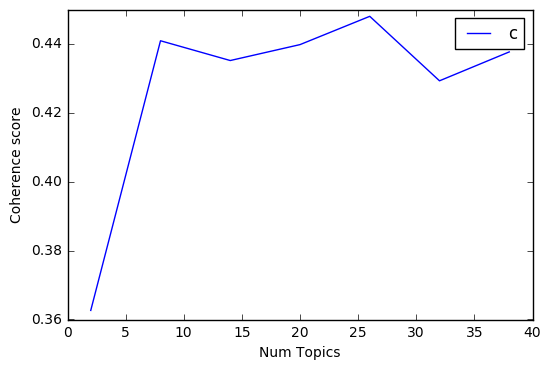

In [118]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [119]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3626
Num Topics = 8  has Coherence Value of 0.4409
Num Topics = 14  has Coherence Value of 0.4352
Num Topics = 20  has Coherence Value of 0.4398
Num Topics = 26  has Coherence Value of 0.448
Num Topics = 32  has Coherence Value of 0.4293
Num Topics = 38  has Coherence Value of 0.4377


In [120]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.024*"taste" + 0.023*"buffet" + 0.023*"good" + 0.016*"small" + '
  '0.016*"rice" + 0.013*"eat" + 0.012*"fish" + 0.012*"dish" + 0.012*"sushi" + '
  '0.012*"item"'),
 (1,
  '0.128*"food" + 0.062*"place" + 0.057*"bad" + 0.050*"eat" + 0.045*"service" '
  '+ 0.034*"give" + 0.032*"star" + 0.031*"time" + 0.021*"review" + '
  '0.018*"horrible"'),
 (2,
  '0.023*"people" + 0.016*"night" + 0.015*"line" + 0.015*"room" + 0.014*"open" '
  '+ 0.013*"pay" + 0.011*"hotel" + 0.010*"stay" + 0.009*"day" + 0.009*"find"'),
 (3,
  '0.096*"good" + 0.060*"place" + 0.050*"food" + 0.036*"price" + '
  '0.018*"pretty" + 0.018*"vegas" + 0.017*"great" + 0.017*"worth" + '
  '0.016*"quality" + 0.012*"thing"'),
 (4,
  '0.042*"order" + 0.035*"chicken" + 0.029*"fry" + 0.028*"pizza" + '
  '0.025*"burger" + 0.019*"taste" + 0.019*"sauce" + 0.017*"cheese" + '
  '0.017*"salad" + 0.015*"meat"'),
 (5,
  '0.055*"restaurant" + 0.025*"meal" + 0.022*"menu" + 0.020*"experience" + '
  '0.020*"dinner" + 0.019*"steak" + 0.018*

## Finding the dominant topic in each sentence

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
df_dominant_topic.to_csv('topic.csv')

TypeError: unorderable types: int() < tuple()

In [24]:
test = lda_model[corpus]

In [33]:
lda_model.get_document_topics(corpus[40])

[(2, 0.082926586),
 (4, 0.094851553),
 (6, 0.01874152),
 (12, 0.059492432),
 (20, 0.0970084),
 (21, 0.31844366),
 (22, 0.19710809),
 (30, 0.11786844)]

In [37]:
lda_model.save('lda_all')

In [22]:
columns = list(range(0,42))

In [23]:
df_topic_prob = pd.DataFrame(columns=columns)
df_topic_prob

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41


In [24]:
for review in corpus:
    topic_prob = [0] * 42
    highest_prob = 0
    dominant_topic = 0
    for item in lda_model.get_document_topics(review):
        topic, prob = item[0], item[1]
        topic_prob[topic] = prob
        if prob > highest_prob:
            dominant_topic = topic
    topic_prob[-1] = dominant_topic
    df_topic_prob = df_topic_prob.append(pd.Series(topic_prob),ignore_index=True)

In [34]:
df_topic_prob = df_topic_prob.rename(columns = {41:'dominant_topic'})

In [40]:
df_topic_prob = df_topic_prob.drop([40],axis=1)
df_topic_prob.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,dominant_topic
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.187777,0.0,0.0,0.0,0.0,0.22686,0.057013,0.0,0.0,0.0,0.0,0.139478,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.067461,0.0,0.000000,0.02031,0.286369,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,30.0
1,0.0,0.0,0.0,0.445955,0.248984,0.0,0.0,0.0,0.226928,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.04599,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,25.0
2,0.0,0.0,0.0,0.325453,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.094963,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.513513,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,30.0
3,0.0,0.0,0.0,0.210440,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.11470,0.000000,0.0,0.0,0.0,0.0,0.378442,0.067209,0.187542,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,21.0
4,0.0,0.0,0.0,0.146859,0.000000,0.0,0.0,0.0,0.036560,0.0,0.0,0.0,0.0,0.00000,0.148260,0.0,0.0,0.0,0.0,0.061888,0.037501,0.041678,0.0,0.0,0.0,0.00000,0.000000,0.0,0.034776,0.00000,0.280801,0.0,0.0,0.18746,0.0,0.0,0.0,0.0,0.0,0.0,33.0


## Save files

In [41]:
df_topic_prob.to_csv('topic_prob.csv')

In [42]:
df_merged = pd.concat([df,df_topic_prob], axis=1)

In [44]:
df_merged.to_csv('review_prob_seattle.csv')

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [45]:
lda_model.save('lda_seattle')

In [48]:
import pickle

with open("corpus_seattle.txt", "wb") as fp:
    pickle.dump(corpus, fp)
    
'''
with open("test.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
'''

'\nwith open("test.txt", "rb") as fp:   # Unpickling\n    b = pickle.load(fp)\n'

In [49]:
df_merged.head()

,inspection_id,restaurant_id,review_id,inspection_penalty_score,rating,content,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,dominant_topic
0,DA2383404,ZriNDCVxkCdVEO-X2sjHFw,review_Q9_9A9QmmpX4unYRcEQc8g,0,5.0,We went here this past weekend with zero expec...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.187777,0.0,0.0,0.0,0.0,0.22686,0.057013,0.0,0.0,0.0,0.0,0.139478,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.067461,0.0,0.000000,0.02031,0.286369,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,30.0
1,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_IveKyEloRTk8bHJ8xcpalA,0,4.0,Lots of young families . Kind of sparse &#160;...,0.0,0.0,0.0,0.445955,0.248984,0.0,0.0,0.0,0.226928,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.04599,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,25.0
2,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_1pIZlx4k7U8S-_dX-kzb4w,0,4.0,Our favorite teriyaki in West Seattle! Generou...,0.0,0.0,0.0,0.325453,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.094963,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.513513,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,30.0
3,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_iaieVt5Tm_US0LTsHMSC6Q,0,4.0,Seattle has a lot of great teriyaki. &#160;Thi...,0.0,0.0,0.0,0.210440,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.11470,0.000000,0.0,0.0,0.0,0.0,0.378442,0.067209,0.187542,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,21.0
4,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_WxjHfhYRD3heTI6ETb7sdg,40,4.0,This place is a gem! My husband and I didn't h...,0.0,0.0,0.0,0.146859,0.000000,0.0,0.0,0.0,0.036560,0.0,0.0,0.0,0.0,0.00000,0.148260,0.0,0.0,0.0,0.0,0.061888,0.037501,0.041678,0.0,0.0,0.0,0.00000,0.000000,0.0,0.034776,0.00000,0.280801,0.0,0.0,0.18746,0.0,0.0,0.0,0.0,0.0,0.0,33.0


## Find the most representative document for each topic

In [122]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5713,"taste, buffet, good, small, rice, eat, fish, d...",We were pretty excited when the signs for Inak...
1,1.0,0.5799,"food, place, bad, eat, service, give, star, ti...",Wir waren dieses Jahr zum zweiten Mal in Vegas...
2,2.0,0.6040,"people, night, line, room, open, pay, hotel, s...",On 28 June 2013 I checked into the Riviera Hot...
3,3.0,0.6335,"good, place, food, price, pretty, vegas, great...","Ayer estuve en este restaurante, yo no lo cono..."
4,4.0,0.4718,"order, chicken, fry, pizza, burger, taste, sau...",I had the trio of sliders for $ 7 \n. The barb...


In [125]:
pprint(sent_topics_sorteddf_mallet.Text.values.tolist())

["Average Teriyaki place on the Ave. &#160;If you're hungry and want a fairly "
 "large portion. &#160;This is the place to go but it's quantity over quality. "
 '&#160;The food is all right. &#160;Never been horrible but never been '
 'amazing either. &#160;Always worth a shot to try those other teriyaki places '
 'on the ave. &#160;There are so many.Nothing special and its usually crowded. '
 '&#160;A good bang for your buck.',
 'My general rule on ethnic restaurants is that you can tell how good it is '
 '&#160;based on how much of their clientele is of that ethnicity. &#160;Think '
 "of that what you will, but it's true. &#160;So when I came into this place "
 'in an aforementioned "grungy" part of town that looked like it belonged in '
 "Belltown, I got skeptical. &#160;But hey, at this point I didn't really "
 'care, I was hungry. &#160;And we were seated right away, which is a plus. '
 '&#160;And then they immediately gave us water and tea, which was another '
 'plus. &#160;Thin

In [3]:
lda_model = gensim.models.ldamodel.LdaModel.load('lda_all', mmap='r')